# Biodiversity Intactness Index(BII) Assessment
The Goal of this assessment will be to create the following map that shows the BII from 2020 with highlighted areas that show where high biodiversity areas were lost from 2017 to 2020.

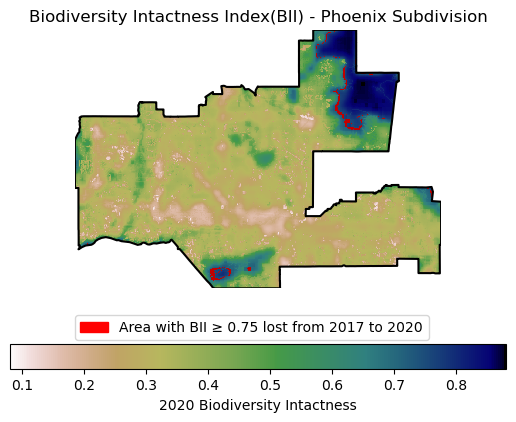
## Context
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001 [1]. Urban sprawl creates pressure on biodiversity and natural areas. In this task you will explore a dataset showing values for a biodiversity intactness index (BII) to find changes in this BII around the Phoenix area from 2017 to 2020. 

1. Levitt, Z., &amp; Eng&nbsp; , J. (2021, August 11). Where America’s developed areas are growing: ‘Way off into the horizon.’ https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/ 

## Data access:
BII data: This dataset is part of the MPC STAC catalog. You will need to access the ‘io-biodiversity’ collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can learn more about the dataset here: Microsoft Planetary Computer. Planetary Computer. (n.d.). https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview 

Phoenix subdivision: You will find the Phoenix subdivision polygon in the Census County Subdivision shapefiles for Arizona: Responsible Party U.S. Department of Commerce, U.S. Census Bureau, Geography Division, Spatial Data Collection and Products Branch (Publisher). (2022, November 1). Tiger/line shapefile, 2021, state, Arizona, county subdivisions. Catalog. https://catalog.data.gov/dataset/tiger-line-shapefile-2021-state-arizona-county-subdivisions 



In [187]:
#load relevant libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import Polygon
import pystac_client 
import planetary_computer
from geogif import gif
import matplotlib.patches as mpatches

## Load in the data
Load in the Arizona County Borders and BII data for future manipulation

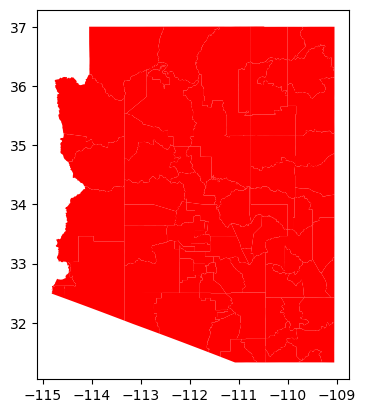

In [188]:
#Read in the Arizona Shapefile
arizona = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
# As a check, plot tht arizona shapeifle to make sure it loaded correctly
arizona.plot(color = 'red')

#Data Cleaning - Make the column names lowercase
arizona.columns = arizona.columns.str.lower()

In [189]:
#Create a Phoenix subdivision by filtering the data to just Phoenix
Phoenix = arizona[arizona['name'] == 'Phoenix']
Phoenix.head()

,statefp,countyfp,cousubfp,cousubns,geoid,name,namelsad,lsad,classfp,mtfcc,cnectafp,nectafp,nctadvfp,funcstat,aland,awater,intptlat,intptlon,geometry
10,04,013,92601,01934968,0401392601,Phoenix,Phoenix CCD,22,Z5,G4040,None,None,None,S,2806478817,9471127,+33.5211331,-112.0284405,"POLYGON ((-112.47014 33.55996, -112.47011 33.5..."


#### BII Data Search
To search for the BII data in the Microsoft Planetary Computer Catalog we will use a list of coordinates defining a bounding box around maricopa, and a timeframe including 2017 and 2020. 

In [190]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

#Define the bounding box for the STAC search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search the Catalog for the 'io-biodiversiy' collection
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime='2016/2023'
)

# get items from search
items = search.item_collection()

## Create a map showing the Phoenix subdivision within an appropriate geographical context



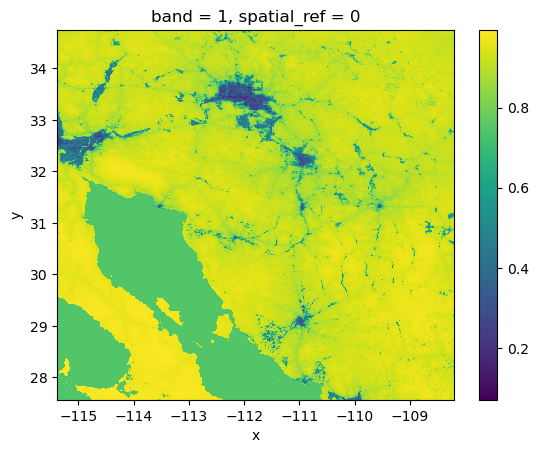

In [191]:
#Save the 2017 Item as a variable
data_2017 = items[3]
#Save the 2020 Item as a variable
data_2020 = items[0]
#Save the 'data' asset of each item as a variable
az_17 = rioxr.open_rasterio(data_2017.assets['data'].href)
az_20 = rioxr.open_rasterio(data_2020.assets['data'].href)
#As a check, plot on of the dataset to confirm they wre selected appropriately
az_17.plot()

#### Reprojecting
In order to overaly and clip any two datasets, we need to make sure they have the same CRS. The following code will reproject the Phoenix data to have the same CRS as the BII data we loaded in.

In [192]:
#Check the CRS
Phoenix.crs
#Change the CRS
Phoenix = Phoenix.to_crs('epsg:4326')
#Check again to make sure it changed
Phoenix.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we can plot the BII data with the Pheonix subdivision highlighted on the map

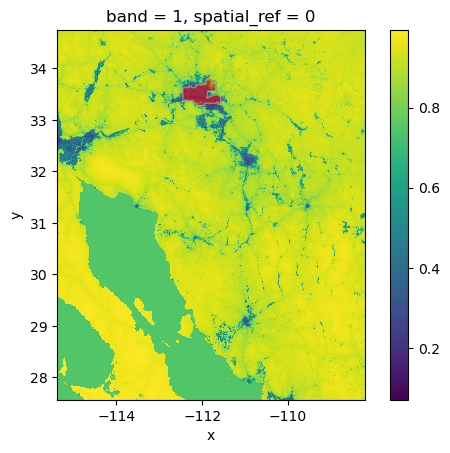

In [193]:
# initialize an empty figure 
fig, ax = plt.subplots()
# -------add layers-------
# add BII 2017 layer
az_17.plot(ax = ax)

# add Phoenix Subdivision
Phoenix.plot(ax = ax,
                alpha = .5, #change the transparency
                color = 'red', #Select the fill color
                edgecolor = '#FFBF65') #Select the edge color
# -----display figure-------
plt.show()

## Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 and 2020
For this section we will clip the BII data to show just the Phoenix subregion, then calculate the total pixels and pixels whre BII ≥ 0.75 to find a percentage.

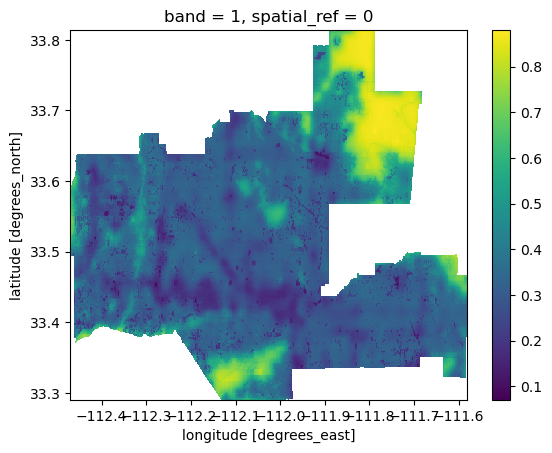

In [194]:
#First Clip the 2017 data
phx_17 = az_17.rio.clip(Phoenix['geometry'])
#Plot to make sure it clipped
phx_17.plot()

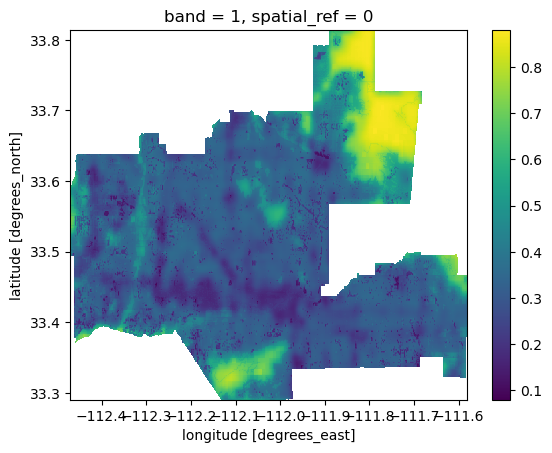

In [195]:
#First Clip the 2020 data
phx_20 = az_20.rio.clip(Phoenix['geometry'])
#Plot to make sure it clipped
phx_20.plot()

We can calculate the total pixels per image by multiplying the width times the height using the `rio.width` and `rio.height` features.

In [196]:
#Calculate the total pixels from the 2017 data
total_pixels_17 = phx_17.rio.width*phx_17.rio.height
#Calculate the total pixels from the 2020 data
total_pixels_20 = phx_20.rio.width*phx_20.rio.height

Then we can create a mask by only selecting areas where the BII was greater than 0.75.

In [197]:
#Create the 2017 mask
lulc_17 = (phx_17 >= 0.75)*1
#Create the 2020 mask
lulc_20 = (phx_20 >= 0.75)*1

The percentage will be calculated by dividing the selected pixels from the total pixels and then multiplying by 100.

In [198]:
#Calculate the 2017 percentage
pct_chn_17 = (lulc_17.values.sum()/total_pixels_17)*100
#Print the values
print(f"The area of the Phoenix subdivision in 2017 with a BII ≥ 0.75 is",pct_chn_17.round(2))
#Calculate the 2020 percentage
pct_chn_20 = (lulc_20.values.sum()/total_pixels_20)*100
#Print the values
print(f"The area of the Phoenix subdivision in 2020 with a BII ≥ 0.75 is",pct_chn_20.round(2))

The area of the Phoenix subdivision in 2017 with a BII ≥ 0.75 is 4.18
The area of the Phoenix subdivision in 2020 with a BII ≥ 0.75 is 3.81


## Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020

In [199]:
#Create a variable that contains the difference in boolean BII values
BII = lulc_17 - lulc_20
# Create a variable where the value was 1 in 2017 or 2020
BII_loss = BII.where(BII == 1)

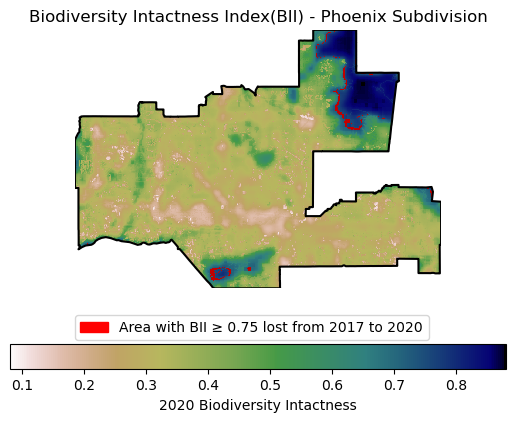

In [200]:
# initialize an empty figure 
fig, ax = plt.subplots()
# --------------add layers-----------------------
#Create the outside Border
Phoenix.boundary.plot(ax=ax, color="black", linewidth=1.5)
#Add the BII layer
phx_20.plot(ax = ax,
            cmap = "gist_earth_r", #customize the cmap
            cbar_kwargs={
                        'label': "2020 Biodiversity Intactness", #Add a legend label
                        'orientation': 'horizontal' #Change the orientation
                         }
            )

# add the layer showing loss from 2027 to 2020
BII_loss.plot(ax = ax,
              cmap = "gist_heat", #Customize the colormap
              add_colorbar = False) #remove the colorbar for the loss

# -----customization separate from the data plotting--------
#Change the figure title and axis labels
ax.set_title('Biodiversity Intactness Index(BII) - Phoenix Subdivision')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

#Create a patch to add a legend for the loss data
patch = mpatches.Patch(color='red', label='Area with BII ≥ 0.75 lost from 2017 to 2020')
ax.legend(handles=[patch], loc = (0,-0.2) )

# Remove the axes/Bounding box
ax.axis('off')

# display figure
plt.show()